In [1]:
import _pickle as cPickle
import pickle as Pickle
%matplotlib qt

In [3]:
with open('/home/rohan/Dropbox/AllenInstitute/CellCount/dat/results/' + 'Labelsv5_epochs_1-summary.pkl', 'rb') as file_pi:
        summary = Pickle.load(file_pi)
with open('/home/rohan/Dropbox/AllenInstitute/CellCount/dat/results/' + 'Labelsv5_epochs_2-summary.pkl', 'rb') as file_pi:
        summary2 = Pickle.load(file_pi)
with open('//home/rohan/Dropbox/AllenInstitute/CellCount/dat/results/' + 'Labelsv5_epochs_3-summary.pkl', 'rb') as file_pi:
        summary3 = Pickle.load(file_pi)

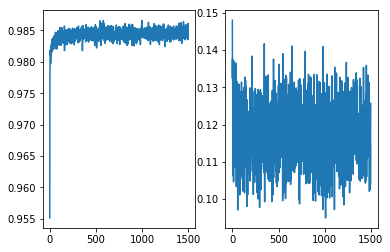

In [4]:
import matplotlib.pyplot as plt
plt.subplot(1,2,1)
plt.plot(summary['acc']+summary2['acc']+summary3['acc'])
plt.subplot(1,2,2)
plt.plot(summary['loss']+summary2['loss']+summary3['loss'])

In [30]:
import seaborn as sns
y = np.array(summary3['acc'])
x = np.arange(np.shape(y)[0])
ax = sns.regplot(x=x, y=y, color="r")
axes = ax.axes

In [2]:
# Adapted from https://github.com/zhixuhao/unet
# In this version, the UNet is trained on 3 classes, and the network returns probabilities of a given pixel belonging to each class. 
# Labels: 0 = background
# Labels: 1 = foreground
# Labels: 2 = boundary

import os
import pdb
import pickle as Pickle
import sys
import time
import timeit
from random import shuffle


#import keras.activations.softmax as Softmax
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
import tensorflow as tf
from keras import backend as K
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras.layers import (Concatenate, Conv2D, Cropping2D, Dropout, Input,
                          MaxPooling2D, UpSampling2D, Dense, Activation)
from keras.losses import binary_crossentropy, mean_squared_error
from keras.models import Model
from keras.optimizers import Adam
from keras.utils import plot_model

import _pickle as cPickle
import fileIO
import im3dscroll as I
from custom_dataloader import DataGenerator
from dataclass import dataset, combine_patches
import pdb


runmode = 'viewresult'#viewresult or train-new

archid = 'Labelsv5_'
nepochs = 1500
batch_size = 4
patchsize = 128
save_period = 50

viewrunid = 'Labelsv5_'
base_path, rel_im_path, rel_lbl_path, rel_result_path = fileIO.set_paths()[0:4]
runid = archid + 'epochs_' + str(nepochs) #+ time.strftime("%Y%m%d-%H%M%S")


#Training data 
train_fileid = ['123','77','60','57','167','68','113','157','143','109','175','95','74','131','111']
train_data = dataset(train_fileid, batch_size=batch_size, patchsize=patchsize,
                        getpatch_algo='random', npatches=10**1, fgfrac=.5,
                        shuffle=True, rotate=True, flip=True)
train_data.load_im_lbl()
train_generator = DataGenerator(train_data)

#Validation data 
val_fileid = ['53','119']
val_data = dataset(val_fileid, batch_size=batch_size, patchsize=patchsize,
                      getpatch_algo='stride', stride=(64, 64), padding=True,
                      shuffle=False, rotate=False, flip=False)
val_data.load_im_lbl()
val_im,val_lbl = val_data.get_patches() #Validation data is not updated while training.

#Define model
conv_properties = {'activation': 'relu', 'padding': 'same', 'kernel_initializer': 'he_normal'}
input_im = Input(shape=(128, 128, 1), name='input_im')

conv1 = Conv2D(8, 3, **conv_properties)(input_im)   # (batch, 128,128,8)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)	    # (batch, 64, 64, 8)

conv2 = Conv2D(8, 3, **conv_properties)(pool1)      # (batch, 64, 64, 8)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)	    # (batch, 32, 32, 8)

conv3 = Conv2D(4, 3, **conv_properties)(pool2)		# (batch, 32, 32, 4)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)	    # (batch, 16, 16, 4)

conv4 = Conv2D(4, 3, **conv_properties)(pool3)		# (batch, 16, 16, 4)
drop4 = Dropout(0.2)(conv4)						    # (batch, 16, 16, 4)
pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)	    # (batch, 8, 8, 4)

conv5 = Conv2D(4, 3, **conv_properties)(pool4)		# (batch, 8, 8, 4)
drop5 = Dropout(0.2)(conv5)						    # (batch, 8, 8, 4)

up6 = UpSampling2D(size=(2, 2))(drop5)			    # (batch, 16, 16, 4)
up6 = Conv2D(4, 2, **conv_properties)(up6)		    # (batch, 16, 16, 4)
cat6 = Concatenate(axis=3)([drop4, up6])  		    # (batch, 16, 16, 4)
conv6 = Conv2D(4, 3, **conv_properties)(cat6)		# (batch, 16, 16, 4)

up7 = UpSampling2D(size=(2, 2))(conv6)			    # (batch, 32, 32, 4)
up7 = Conv2D(4, 2, **conv_properties)(up7)		    # (batch, 32, 32, 4)
cat7 = Concatenate(axis=3)([conv3, up7])		    # (batch, 32, 32, 8)
conv7 = Conv2D(4, 3, **conv_properties)(cat7)		# (batch, 32, 32, 4)

up8 = UpSampling2D(size=(2, 2))(conv7)			    # (batch, 64, 64, 4)
up8 = Conv2D(8, 2, **conv_properties)(up8)		    # (batch, 64, 64, 8)
cat8 = Concatenate(axis=3)([conv2, up8])  		    # (batch, 64, 64, 16)
conv8 = Conv2D(8, 3, **conv_properties)(cat8)		# (batch, 64, 64, 8)

up9 = UpSampling2D(size=(2, 2))(conv8)			    # (batch, 128,128, 8)
up9 = Conv2D(8, 2, **conv_properties)(up9)		    # (batch, 128,128, 8)
cat9 = Concatenate(axis=3)([conv1, up9])  		    # (batch, 128,128, 16)
conv9 = Conv2D(8, 3, **conv_properties)(cat9)		# (batch, 128,128, 8) 

output_im = Conv2D(3,1, activation='softmax', name='output_im')(conv9)
model = Model(inputs=[input_im], outputs=[output_im])


def loss_fcn_wbce(y_true, y_pred):
    all_weights = tf.cast(tf.stop_gradient(1. - tf.reduce_mean(y_pred, axis=[0, 1, 2])), dtype=tf.float32)
    bce = -1. * K.mean((y_true * K.log(y_pred + K.epsilon())) + ((1. - y_true) * K.log(1. - y_pred + K.epsilon())),axis = [0,1,2])
    wbce = all_weights * bce
    return K.mean(wbce,axis = None)

model.compile(optimizer=Adam(),
              loss={'output_im': loss_fcn_wbce},
              metrics=['accuracy'])


#Load weights
model.load_weights(base_path + rel_result_path + 'Labelsv5_epochs_1500' + '/' + '1500' + '.h5')



400/400 [==============================] - 2s 6ms/step


In [3]:
#Load dataset
#imlist = ['53','119','123','77','60','57','167','68','113','157','143','109','175','95','74','131','111']
imlist = ['999']
for imid in imlist:
    D = dataset([imid], batch_size=4, patchsize=patchsize, getpatch_algo='stride',
        shuffle=False, rotate=False, flip=False, stride=(patchsize,patchsize), padding=True)
    D.load_im_lbl()
    val_im,val_lbl = D.get_patches()

    val_im_90 = np.rot90(val_im, k=1, axes=(1,2))
    val_im_180 = np.rot90(val_im, k=2, axes=(1,2))
    val_im_270 = np.rot90(val_im, k=3, axes=(1,2))

    val_lbl_pred = model.predict(val_im, batch_size=1, verbose=1)
    val_lbl_pred_90 = model.predict(val_im_90, batch_size=1, verbose=1)
    val_lbl_pred_180 = model.predict(val_im_180, batch_size=1, verbose=1)
    val_lbl_pred_270 = model.predict(val_im_270, batch_size=1, verbose=1)

    val_lbl_pred_90 = np.rot90(val_lbl_pred_90, k=3, axes=(1,2))
    val_lbl_pred_180 = np.rot90(val_lbl_pred_180, k=2, axes=(1,2))
    val_lbl_pred_270 = np.rot90(val_lbl_pred_270, k=1, axes=(1,2))

    val_lbl_pred = (val_lbl_pred+val_lbl_pred_90+val_lbl_pred_180+val_lbl_pred_270)/4

    val_lbl_bg = np.expand_dims(val_lbl_pred[:,:,:,0],axis=3)
    val_lbl_fg = np.expand_dims(val_lbl_pred[:,:,:,1],axis=3)
    val_lbl_bo = np.expand_dims(val_lbl_pred[:,:,:,2],axis=3)
    val_lbl_predicted = np.expand_dims(np.argmax(val_lbl_pred, axis=3),axis=3)

11750/11750 [==============================] - 145s 12ms/step


In [6]:
val_lbl_full = combine_patches(val_lbl,patchsize=D.patchsize,stride=D.stride,imsize=D.im_buffer[0].shape,padding=True)
val_im_full = combine_patches(val_im,patchsize=D.patchsize,stride=D.stride,imsize=D.im_buffer[0].shape,padding=True)

#lbl_pred_full = combine_patches(val_lbl_pred,patchsize=D.patchsize,stride=D.stride,imsize=D.im_buffer[0].shape,padding=True)
val_lbl_fg = combine_patches(val_lbl_fg,patchsize=D.patchsize,stride=D.stride,imsize=D.im_buffer[0].shape,padding=True)
val_lbl_bo = combine_patches(val_lbl_bo,patchsize=D.patchsize,stride=D.stride,imsize=D.im_buffer[0].shape,padding=True)
val_lbl_predicted = combine_patches(val_lbl_predicted,patchsize=D.patchsize,stride=D.stride,imsize=D.im_buffer[0].shape,padding=True)


sio.savemat('/home/rohan/Desktop/' +'seg999'+'.mat',{'bo':val_lbl_bo,'fg':val_lbl_fg,'im':val_im_full})

In [5]:
D.im_buffer[0].shape

(12000, 16000)